In [1]:
#!/usr/bin/env python
# coding: utf-8

import sys

sys.path.append('/dss/dsshome1/lxc0C/ge32luv/myenv/lib/python3.9/site-packages/')
sys.path.reverse()

import site
import importlib
import pkg_resources

site.addsitedir('/dss/dsshome1/lxc0C/ge32luv/myenv/lib/python3.9/site-packages/')

importlib.reload(pkg_resources)
pkg_resources.get_distribution('google-api-core')

import tensorflow as tf
import tensorflow_quantum as tfq
import sympy

import cirq
from cirq.contrib.svg import SVGCircuit
from cirq.circuits.qasm_output import QasmUGate
from tensorflow_quantum.python.layers.circuit_executors import expectation, sampled_expectation
from tensorflow_quantum.python.layers.circuit_construction import elementary
from tensorflow_quantum.python import util

import numpy as np
import random
import os
import struct
from array import array
from os.path  import join

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import warnings

warnings.filterwarnings("ignore")
import absl.logging

absl.logging.set_verbosity(absl.logging.ERROR)

2025-03-24 12:00:29.549541: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib64/openmpi/lib:/usr/local/cuda/lib64:/opt/intel/oneapi/redist/lib:/opt/postgresql/15.2/lib
2025-03-24 12:00:29.549563: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2025-03-24 12:00:36.040189: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-03-24 12:00:36.040268: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (qlm): /proc/driver/nvidia/version does not exist
2025-03-24 12:00:36.041305: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep

In [2]:
from seqnn_dataLoader import DataLoader

In [3]:
def set_seed(seed: int = 42) -> None:
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.experimental.numpy.random.seed(seed)
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

In [4]:
def vis_samples(imgs, labels, categories):
    labels = [categories[int(label)] for label in np.argmax(labels, axis=1)]
    fig, axs = plt.subplots(1, len(imgs), layout='constrained')
    for i in range(imgs.shape[0]):
        sample = imgs[i][:, :, :3]
        axs[i].imshow(sample)
        axs[i].title.set_text(labels[i])
        axs[i].axis('off')
    plt.show()

In [5]:
def u3(circ, theta, phi, lam, target, cs, ctrl_state):
    circ.append(cirq.rz(lam).on(target).controlled_by(cs[5],cs[4],cs[3],cs[2],cs[1],cs[0], control_values=ctrl_state))
    circ.append(cirq.rx(np.pi/2).on(target).controlled_by(cs[5],cs[4],cs[3],cs[2],cs[1],cs[0], control_values=ctrl_state))
    circ.append(cirq.rz(theta).on(target).controlled_by(cs[5],cs[4],cs[3],cs[2],cs[1],cs[0], control_values=ctrl_state))
    circ.append(cirq.rx(-np.pi/2).on(target).controlled_by(cs[5],cs[4],cs[3],cs[2],cs[1],cs[0], control_values=ctrl_state))
    circ.append(cirq.rz(phi).on(target).controlled_by(cs[5],cs[4],cs[3],cs[2],cs[1],cs[0], control_values=ctrl_state))
    return circ

def cu3(circ, theta, phi, lam, target, cs, ctrl_state):
    circ.append(cirq.rz(lam).on(target).controlled_by(cs[0],cs[1],cs[2],cs[3], control_values=ctrl_state))
    circ.append(cirq.rx(np.pi/2).on(target).controlled_by(cs[0],cs[1],cs[2],cs[3], control_values=ctrl_state))
    circ.append(cirq.rz(theta).on(target).controlled_by(cs[0],cs[1],cs[2],cs[3], control_values=ctrl_state))
    circ.append(cirq.rx(-np.pi/2).on(target).controlled_by(cs[0],cs[1],cs[2],cs[3], control_values=ctrl_state))
    circ.append(cirq.rz(phi).on(target).controlled_by(cs[0],cs[1],cs[2],cs[3], control_values=ctrl_state))
    return circ

def encoding(qubits, circ, inputs, nEncodings, nElements):
    loc = qubits[:6]
    target = qubits[6:9]
    circ.append(cirq.H.on_each(loc))

    for nEncoding in range(nEncodings):
        for i in range(8):
            for j in range(8):
                row = [int(binary) for binary in format(i, '03b')]
                column = [int(binary) for binary in format(j, '03b')]
                ctrl_state = row + column

                circ = u3(circ,
                          inputs[64 * nElements * nEncoding + nElements * (8 * i + j) + 0],
                          inputs[64 * nElements * nEncoding + nElements * (8 * i + j) + 1],
                          inputs[64 * nElements * nEncoding + nElements * (8 * i + j) + 2],
                          target[0], loc, ctrl_state)

                circ = u3(circ,
                          inputs[64 * nElements * nEncoding + nElements * (8 * i + j) + 3],
                          inputs[64 * nElements * nEncoding + nElements * (8 * i + j) + 4],
                          inputs[64 * nElements * nEncoding + nElements * (8 * i + j) + 5],
                          target[1], loc, ctrl_state)

                circ = u3(circ,
                          inputs[64 * nElements * nEncoding + nElements * (8 * i + j) + 6],
                          inputs[64 * nElements * nEncoding + nElements * (8 * i + j) + 7],
                          inputs[64 * nElements * nEncoding + nElements * (8 * i + j) + 8],
                          target[2], loc, ctrl_state)

                circ.append(cirq.CZ(target[0], target[1]))
                circ.append(cirq.CZ(target[1], target[2]))
                circ.append(cirq.CZ(target[2], target[0]))
    return circ


def kernel_prepare(circ, xloc, yloc, target, kernel, readout, symbols0, ctrl):
    loc_states = [[0,0], [1,0], [0,1], [1,1]]
    for i, loc_state in enumerate(loc_states):
        ctrl_state = loc_state + [1] + ctrl
        circ = cu3(circ, symbols0[3*i+0], symbols0[3*i+1], symbols0[3*i+2], 
                   readout, [yloc[0], xloc[0], target, kernel[0]], ctrl_state)
    return circ

def conv_layer(circ, xloc, yloc, target, kernel, readout, symbols0):
    ctrls = [[0], [1]]
    for i, ctrl in enumerate(ctrls):
        circ = kernel_prepare(circ, xloc, yloc, target, kernel, readout, symbols0[12*i:12*i+12], ctrl)
    return circ

def qdcnn(qubits, circ, symbols, nQconv):
    color = qubits[6:9]
    kernel = qubits[9:10]
    readout = qubits[10:12]
    
    circ.append(cirq.H.on_each(kernel))
    
    for i in range(nQconv):
        circ = conv_layer(circ, qubits[3:6], qubits[0:3], color[0], kernel, readout[0], symbols[i*144:i*144+24])
        circ = conv_layer(circ, qubits[4:6], qubits[1:3], readout[0], kernel, readout[1], symbols[i*144+24:i*144+48])
        
        circ = conv_layer(circ, qubits[3:6], qubits[0:3], color[1], kernel, readout[0], symbols[i*144+48:i*144+72])
        circ = conv_layer(circ, qubits[4:6], qubits[1:3], readout[0], kernel, readout[1], symbols[i*144+72:i*144+96])
        
        circ = conv_layer(circ, qubits[3:6], qubits[0:3], color[2], kernel, readout[0], symbols[i*144+96:i*144+120])
        circ = conv_layer(circ, qubits[4:6], qubits[1:3], readout[0], kernel, readout[1], symbols[i*144+120:i*144+144])
        
    return circ  

In [6]:
class Patches(tf.keras.layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        ) 
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, int((32/self.patch_size)**2), patch_dims])
        return patches

    
class Superpixel(tf.keras.layers.Layer):
    def __init__(self, nElements, nEncodings, pool, name="Patch"):
        super(Superpixel, self).__init__(name=name)
        
        self.nElements = nElements
        self.nEncodings = nEncodings
        self.pool = pool

        if dataset == 'overhead':
            self.w = self.add_weight('w', shape=(nEncodings, pool**2, nElements), initializer=tf.keras.initializers.GlorotUniform(), dtype=tf.float32, trainable=True)
        else:    
            self.w = self.add_weight('w', shape=(nEncodings, 4*pool**2, nElements), initializer=tf.keras.initializers.GlorotUniform(), dtype=tf.float32, trainable=True)
        self.b = self.add_weight('biases', shape=(nEncodings, nElements), initializer=tf.keras.initializers.Zeros(), dtype=tf.float32, trainable=True)

    def call(self, inputs):
        
        batch_dim = tf.gather(tf.shape(inputs), 0)
        inputs = Patches(self.pool)(inputs)
        inputs = tf.expand_dims(inputs, 1)
        inputs = tf.tile(inputs, multiples=[1, self.nEncodings, 1, 1])
        outputs = []
        for nEncoding in range(self.nEncodings):
            temp = inputs[:,nEncoding, :,:]
            temp_outs = []
            for i in range(temp.shape[1]):
                tran_weight = self.w[nEncoding]
                temp_patch = temp[:,i]
                temp_out = tf.matmul(temp_patch, tran_weight)
                temp_out = temp_out + self.b[nEncoding]
                temp_out = tf.nn.relu(temp_out)         
                temp_outs.append(temp_out)
            temp_outs = tf.stack(temp_outs, 1)
            outputs.append(temp_outs)
        outputs = tf.stack(outputs, 1)
            
        return tf.reshape(outputs, [batch_dim, self.nElements*64*self.nEncodings])
    
    
class EncodingPQC(tf.keras.layers.Layer):
    def __init__(self, qubits, observables, nEncodings, name="PQC"):
        super(EncodingPQC, self).__init__(name=name)
        self.qubits = qubits
        self.nEncodings = nEncodings
        
        inputs = sympy.symbols(f'img:{64*nElements*nEncodings}')
        params_conv = sympy.symbols(f'conv:{144*nQconv}')
        
        
        circ = cirq.Circuit()
        circ = encoding(self.qubits, circ, inputs, nEncodings, nElements)
        circ = qdcnn(self.qubits, circ, params_conv, nQconv)
        
        self.conv = self.add_weight('conv', shape=(1, len(list(params_conv))), initializer=tf.keras.initializers.RandomUniform(0, 2 * np.pi), dtype=tf.float32, trainable=True) 
    
        self.symbols = [str(symb) for symb in list(inputs) + list(params_conv)]

        self.circ = tfq.convert_to_tensor([circ])
        self.operators = tfq.convert_to_tensor([observables])
        self.executor = expectation.Expectation(backend='noiseless', differentiator=None)    
        
    def call(self, inputs):
        batch_dim = tf.gather(tf.shape(inputs), 0)
        tiled_up_circuits = tf.repeat(self.circ, repeats=batch_dim)
        tiled_up_operators = tf.tile(self.operators, multiples=[batch_dim, 1])
        tiled_up_conv = tf.tile(self.conv, multiples=[batch_dim,1])
       

        joined_vars = tf.concat([inputs, tiled_up_conv], axis=1)
        return self.executor(tiled_up_circuits, symbol_names=self.symbols, symbol_values=joined_vars, operators=tiled_up_operators)


def readout(loc1, loc2, readout, kernel1, entangle1, entangle2, entangle3):
    imgs = []
    imgs.append((1 + cirq.X(loc1))*(1 + cirq.X(loc2))*(1 - cirq.X(readout)))
    imgs.append((1 - cirq.X(loc1))*(1 + cirq.X(loc2))*(1 - cirq.X(readout)))
    imgs.append((1 + cirq.X(loc1))*(1 - cirq.X(loc2))*(1 - cirq.X(readout)))
    imgs.append((1 - cirq.X(loc1))*(1 - cirq.X(loc2))*(1 - cirq.X(readout)))

    kernels = []
    kernels.append((1 + cirq.X(kernel1)))
    kernels.append((1 - cirq.X(kernel1)))

    feature_maps = []
    for img in imgs:
        for kernel in kernels:
            feature_maps.append(img*kernel)

    channels = []
    channels.append((1 - cirq.X(entangle1))*(1 - cirq.X(entangle2))*(1 - cirq.X(entangle3)))
    channels.append((1 + cirq.X(entangle1))*(1 - cirq.X(entangle2))*(1 - cirq.X(entangle3)))
    channels.append((1 - cirq.X(entangle1))*(1 + cirq.X(entangle2))*(1 - cirq.X(entangle3)))
    channels.append((1 + cirq.X(entangle1))*(1 + cirq.X(entangle2))*(1 - cirq.X(entangle3)))
    channels.append((1 - cirq.X(entangle1))*(1 - cirq.X(entangle2))*(1 + cirq.X(entangle3)))
    channels.append((1 + cirq.X(entangle1))*(1 - cirq.X(entangle2))*(1 + cirq.X(entangle3)))
    channels.append((1 - cirq.X(entangle1))*(1 + cirq.X(entangle2))*(1 + cirq.X(entangle3)))
    channels.append((1 + cirq.X(entangle1))*(1 + cirq.X(entangle2))*(1 + cirq.X(entangle3)))

    output = []
    for channel in channels:
        for feature_map in feature_maps:
            output.append(channel*feature_map)
    return output

In [7]:
def build_SEQNN_model():
    qubits = cirq.GridQubit.rect(1, 12)
    readout_operators = readout(qubits[2], qubits[5], qubits[11], qubits[9], qubits[6], qubits[7], qubits[8])

    inputs = tf.keras.Input(shape=(inputSize, inputSize, train_x.shape[-1]))
    patches = Superpixel(nElements, nEncodings, pool)(inputs)
    qpc_layer = EncodingPQC(qubits, readout_operators, nEncodings)(patches)
    activation = tf.keras.layers.Dense(train_y.shape[1], activation='softmax', name='dense')(qpc_layer)

    qcnn_model = tf.keras.Model(inputs=[inputs], outputs=[activation])
    print(qcnn_model.summary())
    
    qcnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                   loss='categorical_crossentropy', metrics=['accuracy'])
    
    return qcnn_model
    

In [8]:
def matrices(model, train_x, train_y, target):
    y_pred = model.predict(train_x)
    y_pred = np.argmax(y_pred, axis=1)
    y_train = np.argmax(train_y, axis=1)

    _, acc = model.evaluate(train_x, train_y)
    print(target+"_best_acc:", acc)

In [9]:
nElements = 9
nEncodings = 1
nQconv = 1
pool = 4
inputSize = 32

(3776, 32, 32, 1) (3776, 5) (667, 32, 32, 1) (667, 5) (557, 32, 32, 1) (557, 5)
['car', 'harbor', 'parking_lot', 'plane', 'ship']


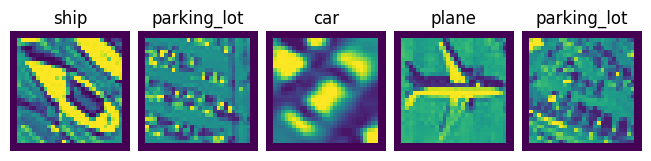

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 Patch (Superpixel)          (None, 576)               153       
                                                                 
 PQC (EncodingPQC)           (None, 64)                144       
                                                                 
 dense (Dense)               (None, 5)                 325       
                                                                 
Total params: 622
Trainable params: 622
Non-trainable params: 0
_________________________________________________________________
None
 96/118 [=======================>......] - ETA: 18s - loss: 0.2046 - accuracy: 0.9316

In [ ]:
dataset = 'overhead'
trained_model_path = 'trained_models/' + dataset + '_optimized_cz_xbasis_model.h5'

dataloader = DataLoader(dataset)
train_x, train_y, valid_x, valid_y, test_x, test_y = dataloader.get_data()
class_name = dataloader.get_categories()

print(train_x.shape, train_y.shape, valid_x.shape, valid_y.shape, test_x.shape, test_y.shape)
print(class_name)

vis_samples(train_x[:5], train_y[:5], class_name)

seqnn_model = build_SEQNN_model()
seqnn_model.load_weights(trained_model_path)

matrices(seqnn_model, train_x, train_y, 'train')
matrices(seqnn_model, valid_x, valid_y, 'val')
matrices(seqnn_model, test_x, test_y, 'test')

In [ ]:
dataset = 'lcz'
trained_model_path = 'trained_models/' + dataset + '_optimized_cz_xbasis_model.h5'

dataloader = DataLoader(dataset)
train_x, train_y, valid_x, valid_y, test_x, test_y = dataloader.get_data()
class_name = dataloader.get_categories()

print(train_x.shape, train_y.shape, valid_x.shape, valid_y.shape, test_x.shape, test_y.shape)
print(class_name)

vis_samples(train_x[:5], train_y[:5], class_name)

seqnn_model = build_SEQNN_model()
seqnn_model.load_weights(trained_model_path)

matrices(seqnn_model, train_x, train_y, 'train')
matrices(seqnn_model, valid_x, valid_y, 'val')
matrices(seqnn_model, test_x, test_y, 'test')

In [ ]:
dataset = 'sat'
trained_model_path = 'trained_models/' + dataset + '_optimized_cz_xbasis_model.h5'

dataloader = DataLoader(dataset)
train_x, train_y, valid_x, valid_y, test_x, test_y = dataloader.get_data()
class_name = dataloader.get_categories()

print(train_x.shape, train_y.shape, valid_x.shape, valid_y.shape, test_x.shape, test_y.shape)
print(class_name)

vis_samples(train_x[:5], train_y[:5], class_name)

seqnn_model = build_SEQNN_model()
seqnn_model.load_weights(trained_model_path)

matrices(seqnn_model, train_x, train_y, 'train')
matrices(seqnn_model, valid_x, valid_y, 'val')
matrices(seqnn_model, test_x, test_y, 'test')